In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.option_context('mode.use_inf_as_na', True)

/opt/homebrew/anaconda3/envs/EVLTR_DS_inFinance/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Data Load & Process

In [2]:
df = pd.read_csv(f"out_df3.csv")

df = df[~df.isin([np.inf, -np.inf]).any(axis=1)]

df.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,hardship_status_filled,loan_id_extracted,emp_title_clean,emp_title_manager,emp_length_clean,Job Title,Category,fico_range_change,debt_to_income,int_rate_clean,term_numeric,interest_per_loan_amnt,grade_encoded,emp_title_clean_encoded,loan_amnt_log,loan_status_rank,annual_inc_log,loan_amnt_std,annual_inc_std,loan_status_binary,hardship_dpd_log,collection_recovery_fee_log,recoveries_log
0,39589826,5000.0,5000.0,5000.0,36 months,10.49%,162.49,B,B3,driver,10+ years,MORTGAGE,55000.0,Not Verified,Jan-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,credit_card,Credit card refinancing,347xx,FL,7.22,0.0,Apr-2010,665.0,669.0,0.0,NaN,61.0,7.0,1.0,6001.0,52.6%,9.0,f,0.0,0.0,5846.672836,5846.67,5000.00,846.67,0.00,0.00,0.000,Jan-2018,162.43,NaN,May-2020,789.0,785.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,159131.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11400.0,NaN,NaN,NaN,4.0,22733.0,4521.0,54.8,0.0,0.0,57.0,57.0,14.0,9.0,1.0,14.0,NaN,1.0,NaN,0.0,3.0,5.0,3.0,3.0,2.0,5.0,6.0,5.0,7.0,0.0,0.0,0.0,1.0,100.0,33.3,0.0,1.0,171118.0,13124.0,10000.0,7526.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,N,NO_HARDSHIP,39589826,driver,False,10.0,NaN,NaN,-120.0,0.090909,0.1049,36,1573.50,1,9633,8.517393,3.0,10.915107,-1.091278,-0.286953,0,0.0,0.000000,0.0000
1,127097355,14000.0,14000.0,14000.0,60 months,13.59%,322.79,C,C2,Shipping Clerk,10+ years,MORTGAGE,48000.0,Source Verified,Jan-2018,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,681xx,NE,24.30,0.0,Apr-2008,735.0,739.0,1.0,NaN,NaN,16.0,0.0,11894.0,27.1%,23.0,w,0.0,0.0,16605.680000,16605.68,14000.00,2605.68,0.00,0.00,0.000,Jul-2019,11128.82,NaN,Feb-2020,779.0,775.0,0.0,N

In [3]:
df = df[~df['emp_length_clean'].isna()]

In [4]:
feature_filter = [
'loan_status_binary', # 1 or 0 for default
'loan_amnt_log', # loan amount logged to avoid skewing by extreme values
'hardship_dpd_log', # more days of hardship expected to increase defaults, logged to avoid skewing
'collection_recovery_fee_log', # charge of collection fee also log for extreme values
'recoveries_log', # charge off gross recoveries log
'annual_inc_std', # incomes can vary wildly, so standardized
'debt_to_income',
'delinq_2yrs',
'fico_range_high',
'fico_range_low',
'fico_range_change', # absolute changes in fico, drastic improvements more likely based on data rather than drastic declines, can also remove abs on this var
'percent_bc_gt_75',
'term_numeric',
'total_pymnt',
'tot_cur_bal',
'installment',
'int_rate_clean',
'emp_title_clean_encoded',
'emp_length_clean'

]

X = df[feature_filter].drop('loan_status_binary', axis=1).copy()
y = df['loan_status_binary']

X = X.dropna()
len(X)

54468

### Baseline Model

In [5]:
non_transform = [col for col in X.columns if '_log' not in col or '_std' not in col]
w_transform = [col for col in X.columns if '_log' in col or '_std' in col]

In [6]:
from dsif6utility import model_evaluation_report

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Split the data into training and testing sets (returns pandas dfs)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

non_transform = [col for col in X.columns if '_log' not in col or '_std' not in col]

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.transform(X)

In [7]:
# Instantiating model
model = LogisticRegression()

model.fit(X_train_scaled, y_train)

LogisticRegression()

In [8]:
# Generating predictions
predictions = model.predict(X_test_scaled)
predictions

array([0, 0, 0, ..., 0, 0, 0])

In [9]:
# confusion matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Calculate metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:,1])

# Display the confusion matrix
cm = confusion_matrix(y_test, predictions)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')
print(f'ROC-AUC: {roc_auc}')
print(f'Confusion Matrix:\n{cm}')


Accuracy: 0.9840279052689553
Precision: 0.9963842975206612
Recall: 0.920324427480916
F1-Score: 0.956845238095238
ROC-AUC: 0.9965774989631578
Confusion Matrix:
[[8791    7]
 [ 167 1929]]


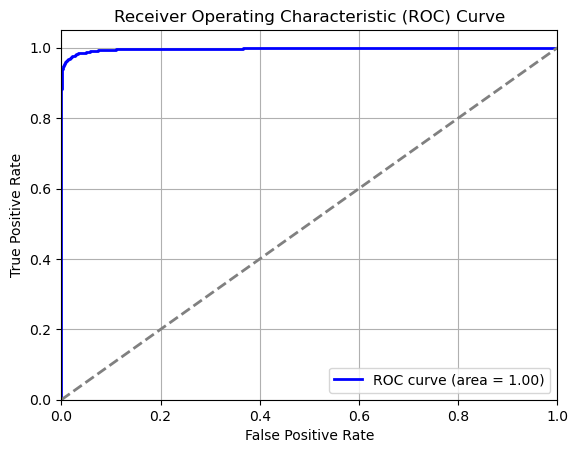

ROC AUC Score: 1.00


In [10]:
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Assuming you have a trained model and test data (X_test, y_test) <<taken from class
# Replace these with your actual data and model
# Example: model = LogisticRegression().fit(X_train, y_train)
# Example: y_pred_prob = model.predict_proba(X_test)[:, 1]

# Compute predicted probabilities (for the positive class)
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]

# Compute ROC curve and ROC AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonal line (random prediction)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Additional stats
print(f'ROC AUC Score: {roc_auc_score(y_test, y_pred_prob):.2f}')


### Challenger Model

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

In [12]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the Model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [13]:
# Step 3: Apply Recursive Feature Elimination (RFE)
from sklearn.feature_selection import RFE

rfe = RFE(estimator=rf,
          n_features_to_select=20, # n_features_to_select = number of features to select
          step=30,                  # step=1 means remove one feature at a time
          verbose = 3)

# Fit RFE to the training data
rfe.fit(X_train, y_train)

# Step 4: Select the top features
selected_features = X_train.columns[rfe.support_]

In [14]:
# Train Model
rf_selected = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selected.fit(X_train[selected_features], y_train)

RandomForestClassifier(random_state=42)

In [15]:
# Make predictions
rf_y_pred = rf.predict(X_test)
rf_y_prob = rf.predict_proba(X_test)[:,1]

model_evaluation_report(X_test, y_test, rf_y_pred, rf_y_prob)

Accuracy: 0.988923566489199
Precision: 0.9986380660537963
Recall: 0.9430868167202572
F1-Score: 0.9700678022159748
ROC-AUC: 0.9972912319090824
Confusion Matrix:
[[13227     4]
 [  177  2933]]


In [16]:

# Model evaluation
y_pred_selected = rf_selected.predict(X_test[selected_features])
y_prob_selected = rf_selected.predict_proba(X_test[selected_features])[:,1]

model_evaluation_report(X_test[selected_features], y_test, y_pred_selected, y_prob_selected)

Accuracy: 0.988923566489199
Precision: 0.9986380660537963
Recall: 0.9430868167202572
F1-Score: 0.9700678022159748
ROC-AUC: 0.9972912319090824
Confusion Matrix:
[[13227     4]
 [  177  2933]]


In [17]:
accuracy = accuracy_score(y_test, y_pred_selected)
precision = precision_score(y_test, y_pred_selected)
recall = recall_score(y_test, y_pred_selected)
f1 = f1_score(y_test, y_pred_selected)
roc_auc = roc_auc_score(y_test, y_prob_selected)

In [18]:
# Plot pair wise correlation:
import seaborn as sns
target = 'loan_status_binary'
flag_plot = False

for col in selected_features:
    # Calculate correlation
    correlation = df[[col, target]].corr().iloc[0, 1]
    
    print(f"Correlation between {col} and {target}: {correlation:.2f}")
    # Create scatter plot
    if flag_plot:
        plt.figure(figsize=(6, 4))
        sns.scatterplot(x=df[col], y=df[target])

        # Add title with correlation value
        plt.xlabel(col)
        plt.ylabel(target)
        # Show plot
        plt.show()

Correlation between loan_amnt_log and loan_status_binary: 0.08
Correlation between hardship_dpd_log and loan_status_binary: 0.09
Correlation between collection_recovery_fee_log and loan_status_binary: 0.79
Correlation between recoveries_log and loan_status_binary: 0.81
Correlation between annual_inc_std and loan_status_binary: -0.04
Correlation between debt_to_income and loan_status_binary: 0.09
Correlation between delinq_2yrs and loan_status_binary: 0.01
Correlation between fico_range_high and loan_status_binary: -0.12
Correlation between fico_range_low and loan_status_binary: -0.12
Correlation between fico_range_change and loan_status_binary: 0.64
Correlation between percent_bc_gt_75 and loan_status_binary: 0.06
Correlation between term_numeric and loan_status_binary: 0.16
Correlation between total_pymnt and loan_status_binary: -0.29
Correlation between tot_cur_bal and loan_status_binary: -0.07
Correlation between installment and loan_status_binary: 0.06
Correlation between int_rate_

In [19]:
importances = rf_selected.feature_importances_
print(type(importances))

<class 'numpy.ndarray'>


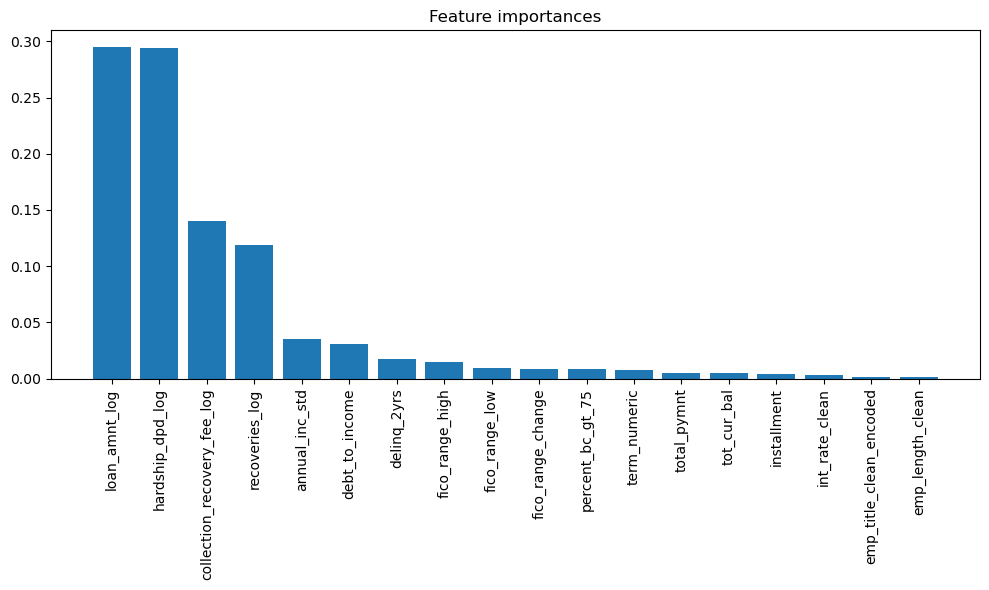

In [20]:
# Sort the array in descending order
indices = np.argsort(importances)[::-1]

col_labels = X.columns

plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X[selected_features].shape[1]), importances[indices], align="center")
plt.xticks(ticks = range(X[selected_features].shape[1])
           , labels = col_labels, rotation=90)
plt.tight_layout()
plt.show()

In [21]:
df.to_csv("/Users/adekolawole/Library/CloudStorage/GoogleDrive-ade.o.kolawole@gmail.com/My Drive/Classroom/ELVTR_DSinFinance_AB/lessons/Capstone_App/app-v3/data/1-raw/dsif11-fraud-detection/loan_application_data.csv")

The logistic regression model performed very well. As a simpler solution it's effective but random forrest allows finer tuning and optimisation using steps and recursive feature elimination (rfe) makes the model more powerful as we learn what features matter most in predicting defaults

In [22]:
# saving off model of choice - random forest
import pickle
import os

path = ''
filename = 'loan_app_random_forrest_model.pkl'

full_path = os.path.join(path, filename)

with open(filename, 'wb') as file:
    pickle.dump(rf, file)

In [23]:
# saving off model of choice - random forest
import pickle
import os

path = ''
filename = 'lr1-loan_app_random_forrest_model.pkl'

full_path = os.path.join(path, filename)

with open(filename, 'wb') as file:
    pickle.dump(rf, file)

In [24]:
[col for col in df.columns if 'term' in col]

['term', 'deferral_term', 'term_numeric']

In [25]:
# Create the DataFrame
df_edit = df[feature_filter + ['loan_amnt', 'int_rate_clean', 'term_numeric']].copy()

# Calculate averages when loan_status_binary == 1
filtered_df_1 = df[df['loan_status_binary'] == 1]
average_loan_amnt_1 = filtered_df_1['loan_amnt'].mean()
average_int_rate_clean_1 = filtered_df_1['int_rate_clean'].mean()
average_term_numeric_1 = filtered_df_1['term_numeric'].mean()

# Calculate averages when loan_status_binary == 0
filtered_df_0 = df[df['loan_status_binary'] == 0]
average_loan_amnt_0 = filtered_df_0['loan_amnt'].mean()
average_int_rate_clean_0 = filtered_df_0['int_rate_clean'].mean()
average_term_numeric_0 = filtered_df_0['term_numeric'].mean()

# Print the results
print(f"Average loan_amnt when loan_status_binary == 1: {average_loan_amnt_1}")
print(f"Average int_rate_clean when loan_status_binary == 1: {average_int_rate_clean_1}")
print(f"Average term_numeric when loan_status_binary == 1: {average_term_numeric_1}")

print(f"Average loan_amnt_log when loan_status_binary == 0: {average_loan_amnt_0}")
print(f"Average int_rate_clean when loan_status_binary == 0: {average_int_rate_clean_0}")
print(f"Average term_numeric when loan_status_binary == 0: {average_term_numeric_0}")

Average loan_amnt when loan_status_binary == 1: 16156.822588463403
Average int_rate_clean when loan_status_binary == 1: 0.15713080950072708
Average term_numeric when loan_status_binary == 1: 45.816383906931655
Average loan_amnt_log when loan_status_binary == 0: 14500.603582995493
Average int_rate_clean when loan_status_binary == 0: 0.1258401014653591
Average term_numeric when loan_status_binary == 0: 41.39052838991688


In [26]:
# Calculate averages across both groups
average_loan_amnt_all = df['loan_amnt'].mean()
average_int_rate_clean_all = df['int_rate_clean'].mean()
average_term_numeric_all = df['term_numeric'].mean()

# Print the results
print(f"Average loan_amnt across both groups: {average_loan_amnt_all}")
print(f"Average int_rate_clean across both groups: {average_int_rate_clean_all}")
print(f"Average term_numeric across both groups: {average_term_numeric_all}")



Average loan_amnt across both groups: 14814.25378203716
Average int_rate_clean across both groups: 0.1317658496732026
Average term_numeric across both groups: 42.22868473231989


Ov